In [1]:
import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras import datasets
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

import numpy as np
import os
import cv2 as cv
from imutils import build_montages
import pickle
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Data preparation

In [2]:
mnist = tf.keras.datasets.fashion_mnist

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0


In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

## Create CNN model

In [13]:
NUM_EPOCHS = 25
LR = 0.001
BATCH_SIZE =32

In [31]:
model = tf.keras.Sequential()
model.add(Conv2D(28, (3, 3), strides=2, padding='same', activation='relu', input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(10, activation='softmax'))

In [32]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="best_weights.hdf5", 
                               monitor = 'val_accuracy',
                               verbose=1, 
                               save_best_only=True)
opt = Adam(lr=LR, decay=LR / NUM_EPOCHS)

In [33]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 14, 14, 28)        280       
_________________________________________________________________
batch_normalization_24 (Batc (None, 14, 14, 28)        112       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 7, 7, 28)          0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 7, 7, 28)          0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 7, 7, 64)          16192     
_________________________________________________________________
batch_normalization_25 (Batc (None, 7, 7, 64)          256       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 3, 3, 64)         

In [36]:
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train[:,:,:, np.newaxis], 
                    y_train, epochs=NUM_EPOCHS, 
                    callbacks=[checkpointer],
                    batch_size=BATCH_SIZE,
                    validation_split=0.2)

# np.expand_dims(a, axis=1)

Train on 48000 samples, validate on 12000 samples
Epoch 1/25
47968/48000 [============================>.] - ETA: 0s - loss: 0.5090 - accuracy: 0.8243
Epoch 00001: val_accuracy improved from 0.83500 to 0.87625, saving model to best_weights.hdf5
48000/48000 [==============================] - 58s 1ms/sample - loss: 0.5089 - accuracy: 0.8244 - val_loss: 0.3362 - val_accuracy: 0.8763
Epoch 2/25
47968/48000 [============================>.] - ETA: 0s - loss: 0.3988 - accuracy: 0.8594
Epoch 00002: val_accuracy did not improve from 0.87625
48000/48000 [==============================] - 57s 1ms/sample - loss: 0.3989 - accuracy: 0.8594 - val_loss: 0.3343 - val_accuracy: 0.8758
Epoch 3/25
47936/48000 [============================>.] - ETA: 0s - loss: 0.3639 - accuracy: 0.8729
Epoch 00003: val_accuracy improved from 0.87625 to 0.89025, saving model to best_weights.hdf5
48000/48000 [==============================] - 57s 1ms/sample - loss: 0.3639 - accuracy: 0.8729 - val_loss: 0.3076 - val_accuracy: 

In [8]:
model.load_weights('best_weights.hdf5')
model.save('shapes_cnn.h5')

In [63]:
with open('trainHistoryOld', 'w') as file_pi:
        pickle.dump(history, file_pi)

NameError: name 'history' is not defined

## Plot learning curve

In [45]:
train_loss, train_acc  = model.evaluate(x_train[:,:,:, np.newaxis], y_train, verbose=False)
print('Trained Acc: ', train_acc)
print('Trained Loss: ', train_loss)

Trained Acc:  0.95995
Trained Loss:  0.11800619754344224


In [37]:
test_loss, test_acc  = model.evaluate(x_test[:,:,:, np.newaxis], y_test, verbose=False)
print('Tested Acc: ', test_acc)
print('Tested Loss: ', test_loss)

Tested Acc:  0.9165
Tested Loss:  0.25894874947667124


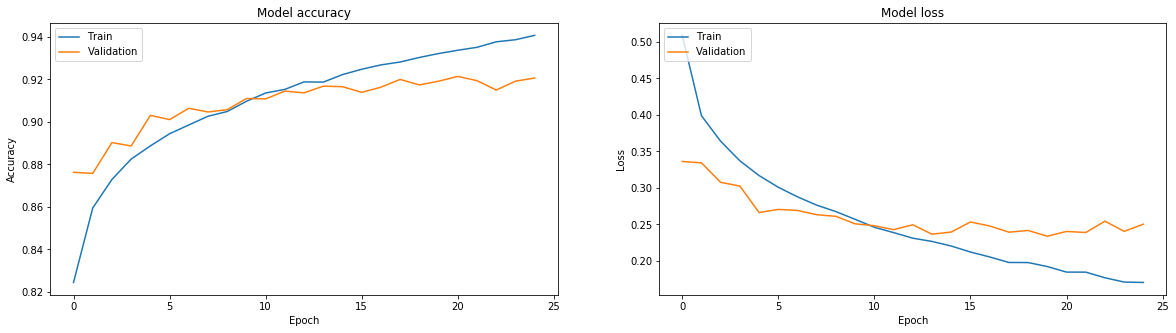

In [44]:
# Plot training & validation accuracy values

fig4, ax4 = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

ax4[0].plot(history.history['accuracy'])
ax4[0].plot(history.history['val_accuracy'])
ax4[0].set_title('Model accuracy')
ax4[0].set(ylabel='Accuracy', xlabel='Epoch')
ax4[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax4[1].plot(history.history['loss'])
ax4[1].plot(history.history['val_loss'])
ax4[1].set_title('Model loss')
ax4[1].set(ylabel='Loss', xlabel='Epoch')
ax4[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Prediction

In [46]:
predictions = model.predict(x_test[:, :, :, np.newaxis])

In [47]:
predicted_args = np.argmax(predictions, axis=1)

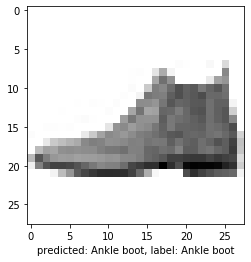

In [48]:
# i = np.random.choice(np.arange(0, len(y_test)))
i=0
fig1, ax1 = plt.subplots()

ax1.set(xlabel='predicted: {}, label: {}'.format(class_names[predicted_args[i]], class_names[y_test[i]]))
ax1.imshow(x_test[i], cmap=plt.cm.binary)

## Plot activations of the first layer

(1000, 14, 14, 28)


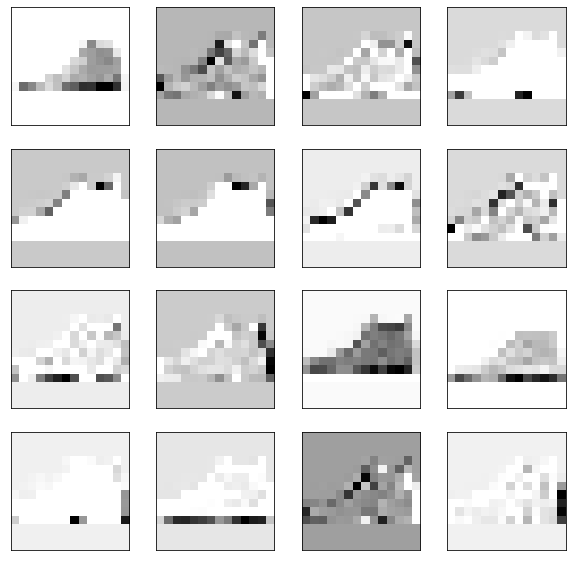

In [50]:
layer_outputs = [layer.output for layer in model.layers] 
activation_model = tf.keras.Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(x_test[:1000,:,:, np.newaxis]) 
# Returns a list of five Numpy arrays: one array per layer activation

first_layer_activation = activations[0]
print(first_layer_activation.shape)

# plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

fig2, ax2 = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for axis, i in zip(ax2.ravel(), range(16)):
    axis.set_xticks([])
    axis.set_yticks([])
    axis.grid(False)
    axis.imshow(activations[0][0, :, :, i], cmap=plt.cm.binary)

## Fashion MNIST classification

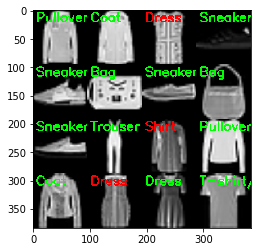

In [54]:
# initialize list of output images
images = []
 
# randomly select a few testing fashion items
random_choice = np.random.choice(np.arange(0, len(y_test)), size=(16,))
for i in random_choice:
    # classify the clothing
#     probs = model.predict(testX[np.newaxis, i])
#     prediction = probs.argmax(axis=1)
#     label = labelNames[prediction[0]]
 
    # otherwise we are using "channels_last" ordering
    image = (x_test[i] * 255).astype("uint8")
    
    # initialize the text label color as green (correct)
    color = (0, 255, 0)
 
    # otherwise, the class label prediction is incorrect
    if predicted_args[i] != y_test[i]:
        color = (255, 0, 0)
 
    # merge the channels into one image and resize the image from
    # 28x28 to 96x96 so we can better see it and then draw the
    # predicted label on the image
    image = cv.merge([image] * 3)
    image = cv.resize(image, (96, 96), interpolation=cv.INTER_LINEAR)
    cv.putText(image, class_names[y_test[i]], (5, 20), cv.FONT_HERSHEY_SIMPLEX, 0.75,
        color, 2)
 
    # add the image to our list of output images
    images.append(image)
 
# construct the montage for the images
montage = build_montages(images, (96, 96), (4, 4))[0]
 
# show the output montage
plt.imshow(montage, cmap=plt.cm.binary)
# cv.imshow("Fashion MNIST", montage)
# cv.waitKey(0)

## Playing around with matplotlib

In [55]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)
    
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

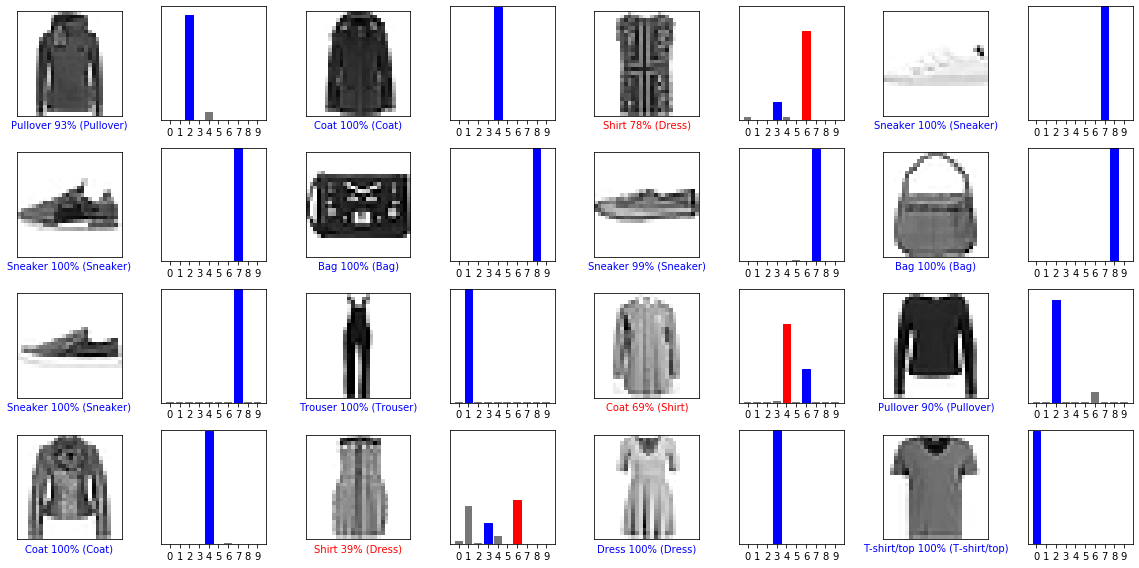

In [56]:
num_rows = 4
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
j = 0
for i in random_choice:
    plt.subplot(num_rows, 2*num_cols, 2*j+1)
    plot_image(i, predictions[i], y_test, x_test)
    plt.subplot(num_rows, 2*num_cols, 2*j+2)
    plot_value_array(i, predictions[i], y_test)
    j += 1
plt.tight_layout()
plt.show()